In [2]:
import Pkg
Pkg.add("StatsPlots")

    Updating registry at `/srv/julia/pkg/registries/General.toml`
   Resolving package versions...
   Installed IntelOpenMP_jll ─── v2018.0.3+2
   Installed OffsetArrays ────── v1.12.7
   Installed SentinelArrays ──── v1.3.13
   Installed Distances ───────── v0.10.7
   Installed FFTW ────────────── v1.5.0
   Installed Ratios ──────────── v0.4.3
   Installed NearestNeighbors ── v0.4.11
   Installed MKL_jll ─────────── v2022.0.0+0
   Installed StatsPlots ──────── v0.14.34
   Installed KernelDensity ───── v0.6.3
   Installed FFTW_jll ────────── v3.3.10+0
   Installed AbstractFFTs ────── v1.2.1
   Installed Clustering ──────── v0.14.2
   Installed DataValues ──────── v0.4.13
   Installed Arpack_jll ──────── v3.5.1+1
   Installed Widgets ─────────── v0.6.6
   Installed TableOperations ─── v1.2.0
   Installed AxisAlgorithms ──── v1.0.1
   Installed Arpack ──────────── v0.5.3
   Installed MultivariateStats ─ v0.9.0
   Installed Observables ─────── v0.5.1
   Installed WoodburyMatrices ── v0.5.

In [3]:
using Random, Distributions, LinearAlgebra, ForwardDiff, Plots, StatsPlots
Random.seed!(123)

TaskLocalRNG()

# Distribuição de referência

$\pi(\theta) = \kappa \exp\left\{-0.5(\theta_1^2\theta_2^2+\theta_1^2+\theta_2^2-8\theta_1-8\theta_2\right)\}$

In [4]:
function π(θ)
    exp(-1/2 *  (prod(θ)^2 + sum(θ.^2) - 8 * sum(θ)) )
end

π (generic function with 1 method)

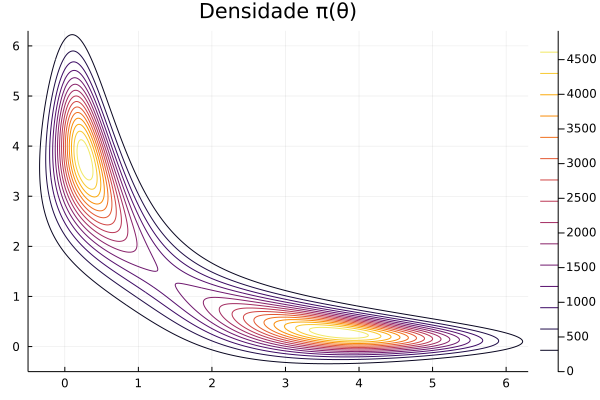

In [5]:
x = -0.5:0.01:6.3;
y = -0.5:0.01:6.3;
contour(x, y, (x,y) -> π((x,y)), title="Densidade π(θ)")

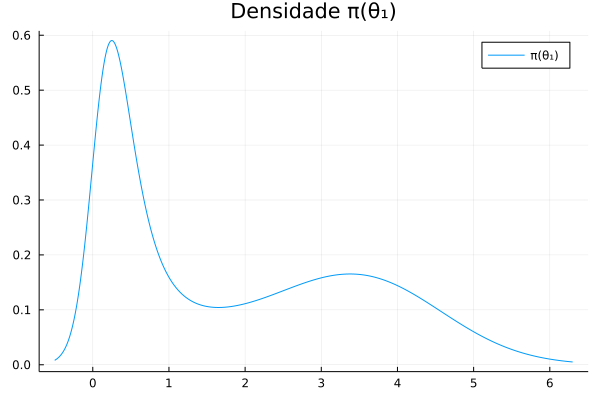

In [6]:
Z = zeros(size(x)[1], size(y)[1])
for (i, u) in enumerate(x)
    for (j, v) in enumerate(y)
        Z[i,j] = π([u,v])
    end
end
plot(x, sum(Z, dims=2) / sum(Z) * 100, title="Densidade π(θ₁)", label="π(θ₁)")

# Random Walk Metropolis

In [106]:
function RWM(σ, burn_in, N)
    burnin = 10000
    N      = 10000
    n_iter  = burnin + N

    MH = zeros(n_iter, 2)
    θ = [0, 0]

    for t = 1:n_iter
        θₜ = rand(MvNormal(θ, σ * I(2)))
        r = π(θₜ) / π(θ)
        if rand() < r
            θ = θₜ
        end
        MH[t,:] = θ
    end
    return MH
end

RWM (generic function with 2 methods)

## Exemplo 1

n_iter = 20.000

$\sigma = 0.01$ 

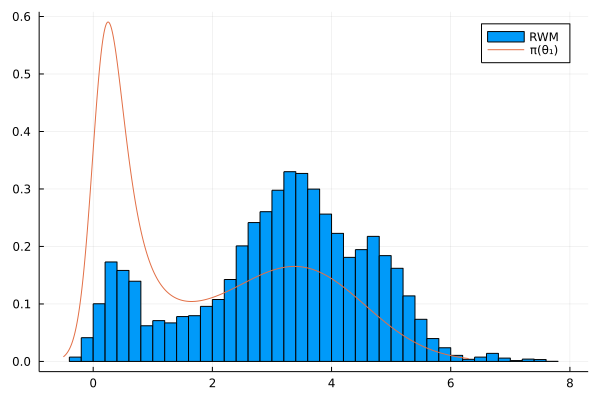

In [110]:
E1 = RWM(0.01, 10000, 10000)
histogram(E1[:, 1], normed=true, label="RWM", bins=50)
plot!(x, sum(Z, dims=2) / sum(Z) * 100, label="π(θ₁)")

## Exemplo 2

n_iter = 20.000

$\sigma = 0.1$ 

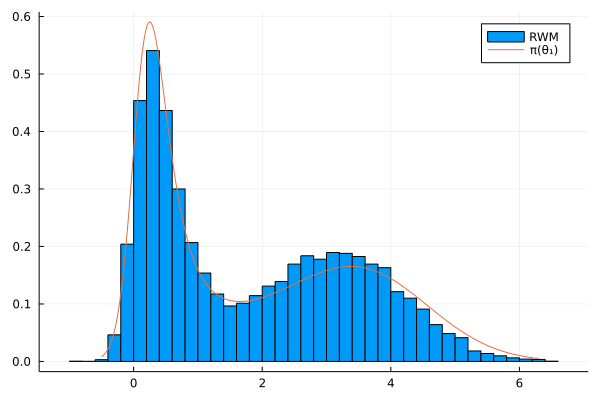

In [111]:
E1 = RWM(0.1, 10000, 10000)
histogram(E1[:, 1], normed=true, label="RWM", bins=50)
plot!(x, sum(Z, dims=2) / sum(Z) * 100, label="π(θ₁)")

# Hamiltonian Monte Carlo

In [7]:
function U(θ)
    -log(π(θ))
end

U (generic function with 1 method)

In [8]:
function dU(U, θ)
    ForwardDiff.gradient(U, θ)
end

dU (generic function with 1 method)

In [9]:
function K(ρ, M)
    1/2 * ρ' * M^-1 * ρ
end

K (generic function with 1 method)

In [10]:
function leapfrog_step(θ, ρ, U, dU, M, L, ϵ)
    ρ = ρ - ϵ/2 * dU(U, θ)
    θ = θ + ϵ * M^-1 * ρ
    ρ = ρ - ϵ/2 * dU(U, θ)
    return(θ, ρ)
end

leapfrog_step (generic function with 1 method)

In [11]:
function metropolis_step(θ, ρ, θₜ, ρₜ, U, K, M)
    r = exp(U(θ) - U(θₜ) + K(ρ, M) - K(ρₜ, M))
    u = rand(Uniform())
    if u < r
        return(θₜ, -ρₜ)
    else
        return(θ, ρ)
    end
end

metropolis_step (generic function with 1 method)

In [12]:
function HMC(θ, U, dU, K, M, L, ϵ, num_iter)
    d = size(θ, 1)
    Θ = zeros(num_iter, d)
    Ρ = zeros(num_iter, d)

    for t = 1:num_iter

        # Amostra ρ
        Σ = cholesky(M).L
        P = MvNormal(Σ)
        ρ = rand(P)

        # Inicializa estado no passo t
        ρₜ = ρ
        θₜ = θ

        # Leapfrog steps
        for l = 1:L
            θₜ, ρₜ = leapfrog_step(θₜ, ρₜ, U, dU, M, L, ϵ)
        end

        # Metropolis step
        θ, ρ = metropolis_step(θ, ρ, θₜ, ρₜ, U, K, M)

        # Registra valores amostrados
        Θ[t,:] = θ
        Ρ[t,:] = ρ

    end
    return((Θ, Ρ))
end

HMC (generic function with 1 method)

## Exemplo 1

Poucos leapfrog steps, $\epsilon$ pequeno:

$L = 10$

$\epsilon = 0.001$

In [74]:
d = 2
θ₀ = rand(d)
M = I(d)
L = 10
ϵ = 0.001
burn_in = 10000
N = 10000
num_iter = burn_in + N;

In [75]:
A, B = HMC(θ₀, U, dU, K, M, L, ϵ, num_iter);

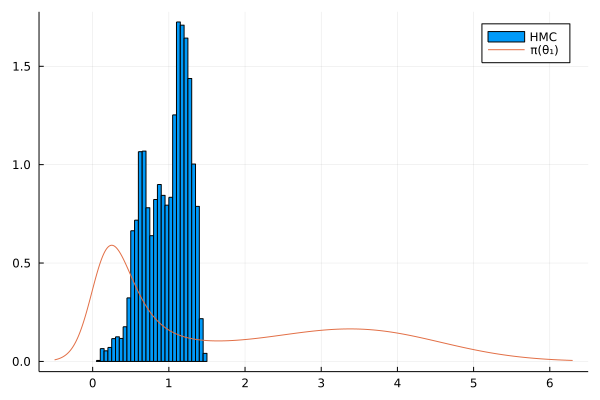

In [76]:
histogram(A[:, 1], normed=true, label="HMC", bins=50)
plot!(x, sum(Z, dims=2) / sum(Z) * 100, label="π(θ₁)")

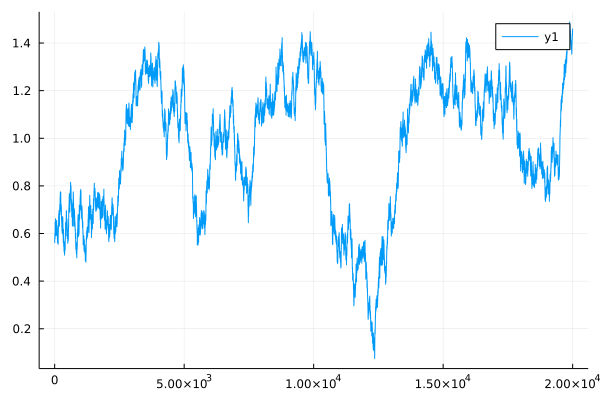

In [78]:
plot(1:num_iter, A[:, 1])

## Exemplo 2

Aumentando leapfrog steps, $\epsilon$ pequeno:

$L = 100$

$\epsilon = 0.1$

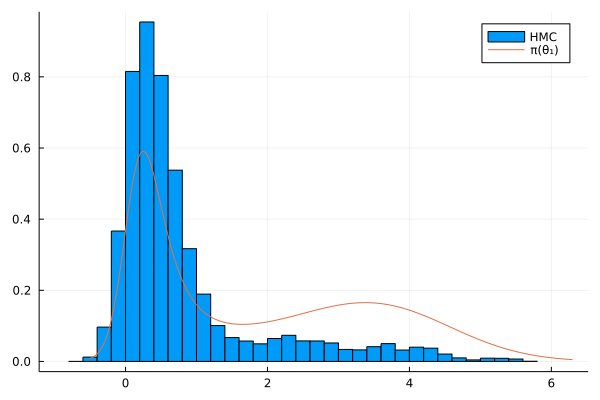

In [79]:
d = 2
θ₀ = rand(d)
M = I(d)
L = 100
ϵ = 0.001
burn_in = 10000
N = 10000
num_iter = burn_in + N;

C, D = HMC(θ₀, U, dU, K, M, L, ϵ, num_iter);

histogram(C[:, 1], normed=true, label="HMC", bins=50)
plot!(x, sum(Z, dims=2) / sum(Z) * 100, label="π(θ₁)")

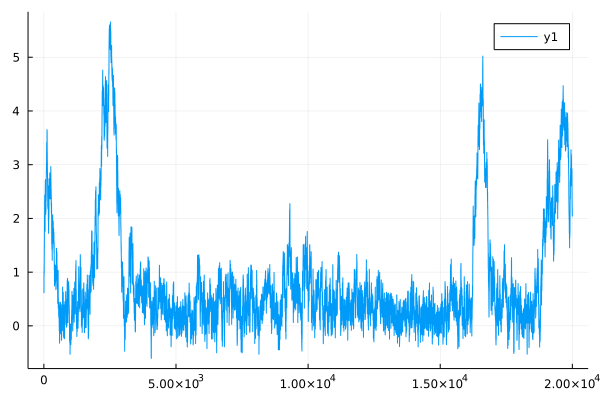

In [80]:
plot(1:num_iter, C[:, 1])

## Exemplo 3

Muitos leapfrog steps, $\epsilon$ médio:

$L = 100$

$\epsilon = 0.01$

In [81]:
d = 2
θ₀ = rand(d)
M = I(d)
L = 100
ϵ = 0.01
burn_in = 10000
N = 10000
num_iter = burn_in + N;

In [82]:
D, E = HMC(θ₀, U, dU, K, M, L, ϵ, num_iter);

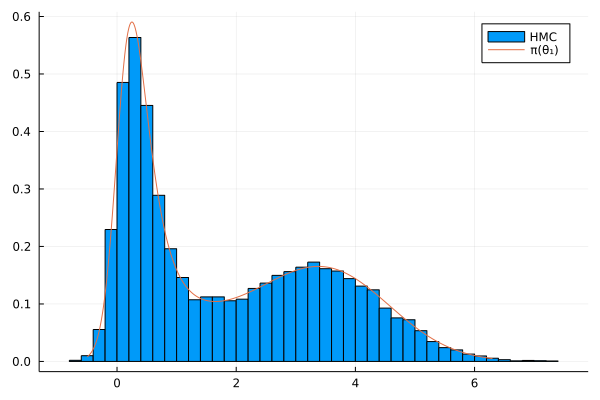

In [84]:
histogram(D[:, 1], normed=true, label="HMC", bins=50)
plot!(x, sum(Z, dims=2) / sum(Z) * 100, label="π(θ₁)")

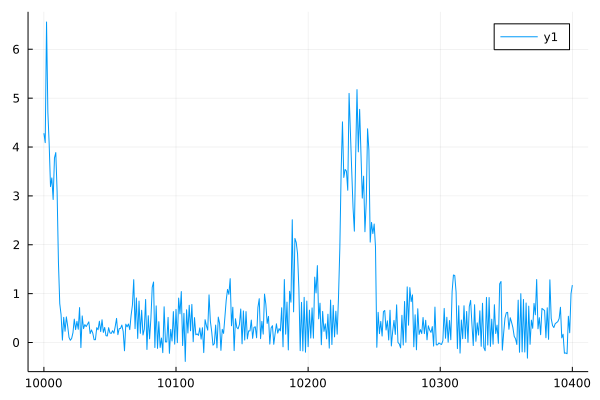

In [89]:
plot(burn_in:burn_in+400, D[burn_in:burn_in+400, 1])

## Exemplo 4

Poucos leapfrog steps, $\epsilon$ grande:

$L = 10$

$\epsilon = 0.1$

In [85]:
d = 2
θ₀ = rand(d)
M = I(d)
L = 10
ϵ = 0.1
burn_in = 10000
N = 10000
num_iter = burn_in + N;

In [90]:
F, G = HMC(θ₀, U, dU, K, M, L, ϵ, num_iter);

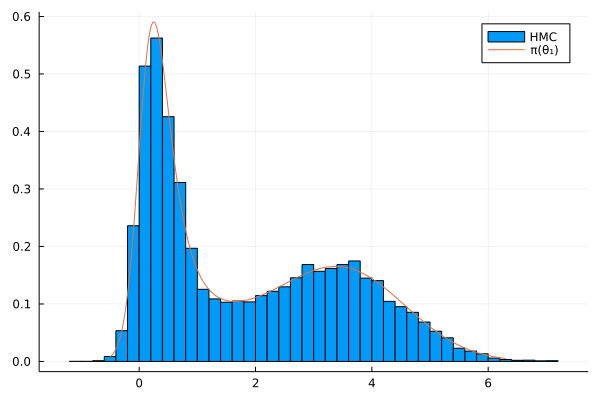

In [91]:
histogram(F[:, 1], normed=true, label="HMC", bins=50)
plot!(x, sum(Z, dims=2) / sum(Z) * 100, label="π(θ₁)")

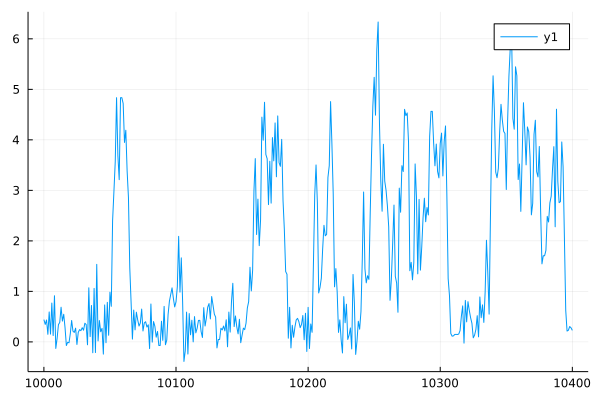

In [92]:
plot(burn_in:burn_in+400, F[burn_in:burn_in+400, 1])